In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
sns.set(rc={'figure.figsize':(11, 4)})

read data and keep the data from Dec,31 2012.

,Energy_Generated,Efficiency,Energy_Exported,Energy_Used,Peak_Power,Peak_Time,Condition,Min_Temperature,Max_Temperature,Peak_Energy_Import,Off-Peak_Energy_Import,Shoulder_Energy_Import,High-Shoulder_Energy_Import,Insolation
Date,,,,,,,,,,,,,,
2019-04-25,3144,2.911,2977,0,984,13:20,Partly Cloudy,9,22,NaN,NaN,NaN,NaN,6308
2019-04-26,2715,2.514,2399,0,985,16:40,Partly Cloudy,3,17,NaN,NaN,NaN,NaN,6315
2019-04-27,2477,2.294,2049,0,1041,15:40,Partly Cloudy,7,20,NaN,NaN,NaN,NaN,6323
2019-04-28,3788,3.507,3693,0,963,13:00,Fine,7,21,NaN,NaN,NaN,NaN,6330
2019-04-29,3265,3.023,2706,0,1010,13:50,Partly Cloudy,3,24,NaN,NaN,NaN,NaN,6336


2259


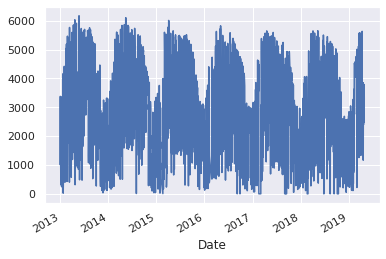

In [2]:
data = pd.read_pickle("../DATA_COLLECTOR/AGGREGATION_PRODUCTION/aggreg_PRODUCTION_data.pkl")
data.Date = pd.to_datetime(data['Date'],format='%Y%m%d')
data = data.sort_values(by='Date')
data = data[data.Date > '2012-12-31']
data = data.set_index('Date')

display(data.tail())
print(len(data))


data.Energy_Generated = pd.to_numeric(data.Energy_Generated)
data.Energy_Generated.plot()

Split data into train and test

In [3]:
thresh_date = '2018-12-31' #'2019-02-07', '2019-08-31'
train_data = data[data.index < thresh_date]
test_data = data[data.index > thresh_date]
display(train_data.head(2))
display(test_data.head(2))

print("Train size %d, test size %d" % (len(train_data), len(test_data)))

,Energy_Generated,Efficiency,Energy_Exported,Energy_Used,Peak_Power,Peak_Time,Condition,Min_Temperature,Max_Temperature,Peak_Energy_Import,Off-Peak_Energy_Import,Shoulder_Energy_Import,High-Shoulder_Energy_Import,Insolation
Date,,,,,,,,,,,,,,
2013-01-01,1013,0.938,998,0,807,13:10,Showers,8,13,NaN,NaN,NaN,NaN,3458
2013-01-02,2878,2.665,2840,0,837,13:00,Mostly Cloudy,7,13,NaN,NaN,NaN,NaN,3472


,Energy_Generated,Efficiency,Energy_Exported,Energy_Used,Peak_Power,Peak_Time,Condition,Min_Temperature,Max_Temperature,Peak_Energy_Import,Off-Peak_Energy_Import,Shoulder_Energy_Import,High-Shoulder_Energy_Import,Insolation
Date,,,,,,,,,,,,,,
2019-01-01,2022,1.872,1637,0,744,13:05,Fine,-2,9,NaN,NaN,NaN,NaN,3243
2019-01-02,277,0.256,88,0,116,14:40,Showers,2,4,NaN,NaN,NaN,NaN,3255


Train size 2139, test size 119


get daily production from MA with a window of 28 day ; resample the data weekly,monthly

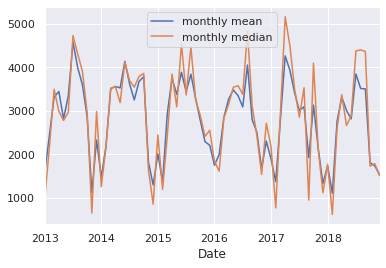

In [4]:
monthly_data_mean = train_data.Energy_Generated.resample('M').mean()
monthly_data_median = train_data.Energy_Generated.resample('M').median()
monthly_data_mean.plot(label='monthly mean')
monthly_data_median.plot(label='monthly median')
plt.legend()

weekly_data_mean = train_data.Energy_Generated.resample('W').mean()

Text(0.5, 1.0, 'Trends in Generated Energy')

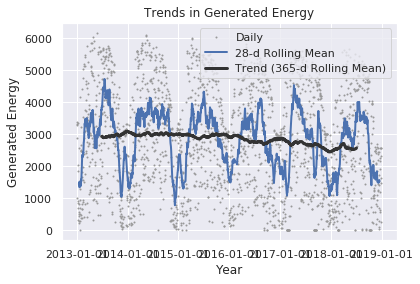

In [5]:
rolling_data_28day = train_data.Energy_Generated.rolling(28, center=True).mean()
rolling_data_365day = train_data.Energy_Generated.rolling(window=365, center=True, min_periods=360).mean()
rolling_data_28day = rolling_data_28day.dropna()


# Plot daily, 28-day rolling mean, and 365-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(train_data.Energy_Generated, marker='.', markersize=2, color='0.6',
linestyle='None', label='Daily')
ax.plot(rolling_data_28day, linewidth=2, label='28-d Rolling Mean')
ax.plot(rolling_data_365day, color='0.2', linewidth=3,
label='Trend (365-d Rolling Mean)')
# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Generated Energy')
ax.set_title('Trends in Generated Energy')

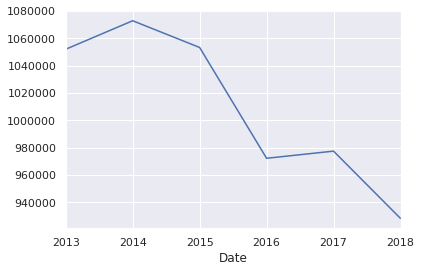

In [6]:
annual_data_sum = train_data.Energy_Generated.resample('A').sum()
annual_data_sum.plot()

<Figure size 432x288 with 0 Axes>

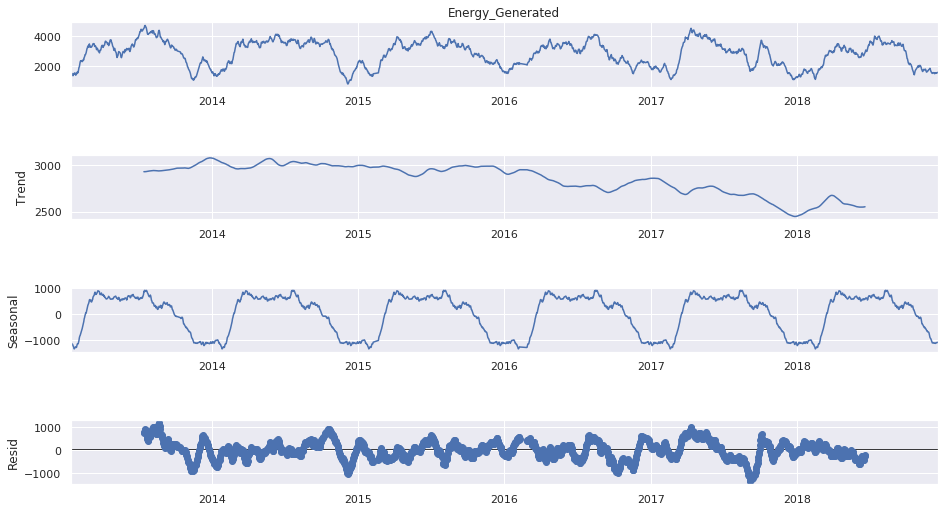

In [7]:
decomposition = seasonal_decompose(rolling_data_28day,period=360) 
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

<Figure size 432x288 with 0 Axes>

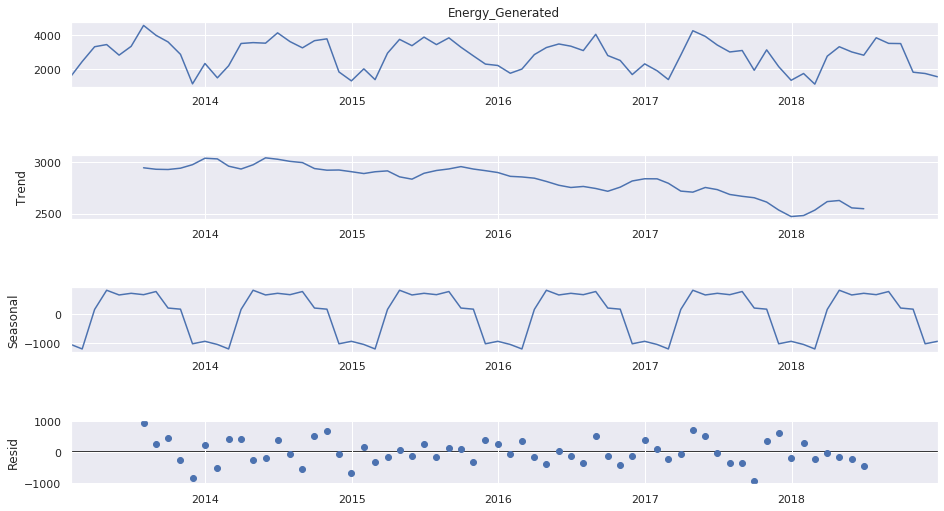

In [8]:
decomposition = seasonal_decompose(monthly_data_mean,period=12) 
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

<Figure size 432x288 with 0 Axes>

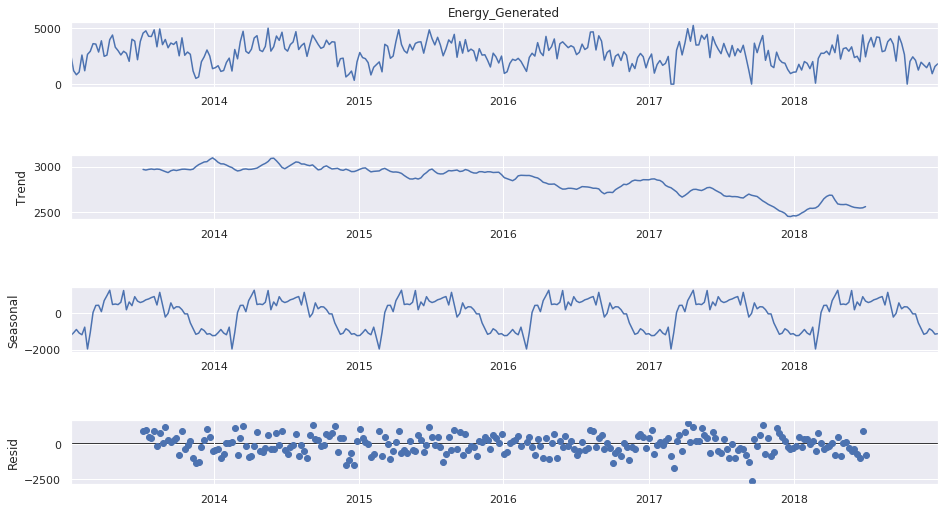

In [9]:
weekly_data_mean =weekly_data_mean.dropna()
decomposition = seasonal_decompose(weekly_data_mean,period=52) 
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

SARIMA on weekly mean production and monthly mean production

In [10]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):  
    #Determing rolling statistics
    rolmean = timeseries.rolling(12, center=True).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig  = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std  = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

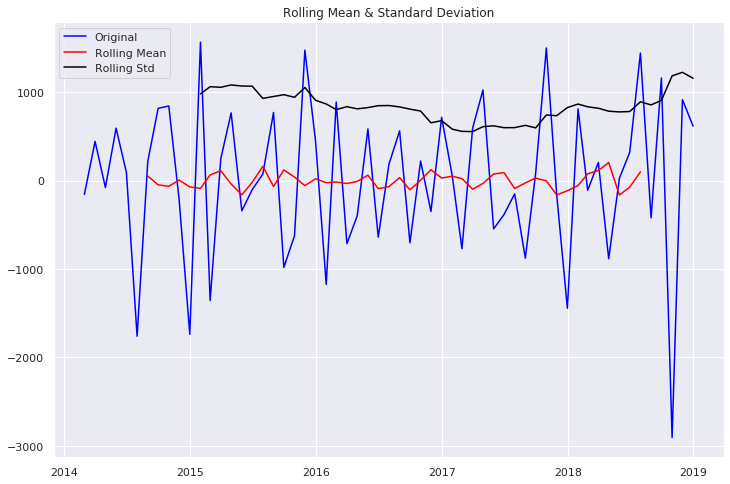

Results of Dickey-Fuller Test:
Test Statistic                -6.572223e+00
p-value                        7.883918e-09
#Lags Used                     4.000000e+00
Number of Observations Used    5.400000e+01
Critical Value (1%)           -3.557709e+00
Critical Value (5%)           -2.916770e+00
Critical Value (10%)          -2.596222e+00
dtype: float64


In [11]:
monthly_data_mean_first_diff = monthly_data_mean - monthly_data_mean.shift(1)  
monthly_data_mean_seasonal_first_difference = monthly_data_mean_first_diff - monthly_data_mean_first_diff.shift(12)
test_stationarity(monthly_data_mean_seasonal_first_difference.dropna(inplace=False))

Autocorrelation study to check the s,p,d,q order

/home/zhe/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


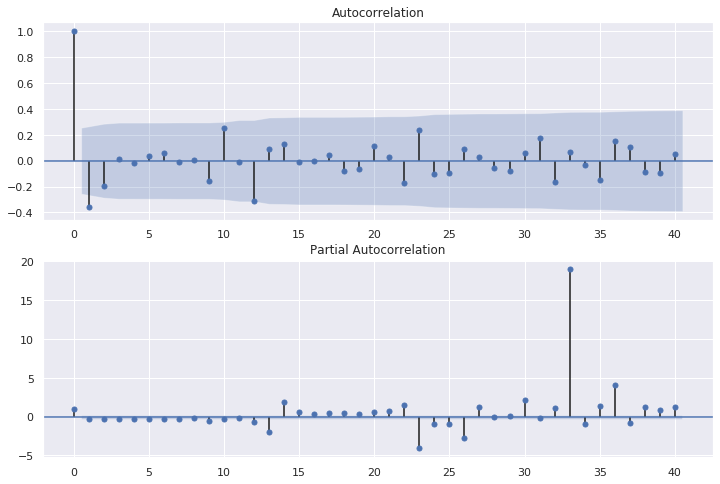

In [12]:
import statsmodels.api as sm 

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(monthly_data_mean_seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(monthly_data_mean_seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

In [13]:
mod = sm.tsa.statespace.SARIMAX(monthly_data_mean, trend='n', order=(0,1,2), seasonal_order=(0,1,2,12))
results = mod.fit()
print(results.summary())

/home/zhe/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/zhe/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


                                     SARIMAX Results                                      
Dep. Variable:                   Energy_Generated   No. Observations:                   72
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 12)   Log Likelihood                -455.328
Date:                            Tue, 31 Mar 2020   AIC                            920.657
Time:                                    14:23:07   BIC                            931.044
Sample:                                01-31-2013   HQIC                           924.712
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9909      0.284     -3.494      0.000      -1.547      -0.435
ma.L2         -0.0087      0.143   

Residual analyse

count      72.000000
mean      -58.946388
std       670.907798
min     -1946.852573
25%      -533.600962
50%       -16.486492
75%       395.023178
max      1567.161290
dtype: float64


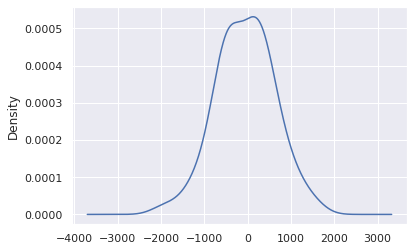

In [14]:
residuals = results.resid
#residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

prediction for monthly data

In [15]:
test_monthly_data_mean = test_data.Energy_Generated.resample('M').mean()
M_test_size = len(test_monthly_data_mean)
print(M_test_size)

4


2019-01-31    1541.607003
2019-02-28    1379.976021
2019-03-31    2698.849888
2019-04-30    3414.276203
2019-05-31    3206.028706
Freq: M, dtype: float64


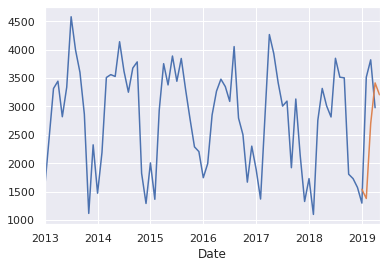

In [16]:
end   = M_test_size + monthly_data_mean.shape[0]
start = monthly_data_mean.shape[0]
forecast_values = results.predict(start=start, end=end, dynamic=True)
all_monthly_data_mean = data.Energy_Generated.resample('M').mean()
all_monthly_data_mean.plot()
forecast_values.plot()

print(forecast_values)

LSTM 

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

Not Sure


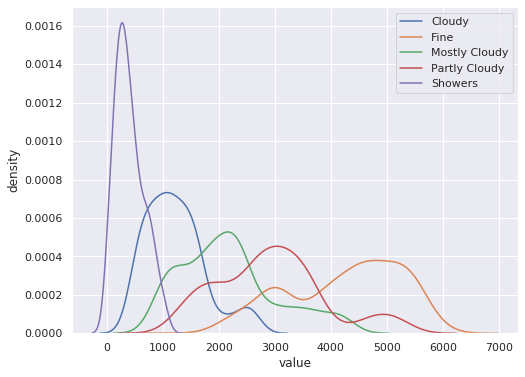

In [4]:
conditions = data.Condition.values
fig, ax = plt.subplots(figsize=(8,6))
for label in np.unique(conditions):
    # this is to plot the kde
    try:
        sns.kdeplot(data.Energy_Generated[data.Condition == label],label=label)
    except:
        print(label)
plt.xlabel('value')
plt.ylabel('density')
plt.show()

In [5]:
features = ['Condition','Energy_Generated']
daily_data_with_weather = data[features]
conditions = set(daily_data_with_weather['Condition'])

encoder = LabelEncoder()
daily_data_with_weather.Condition = encoder.fit_transform(daily_data_with_weather.Condition)
conditions_labels = set(daily_data_with_weather['Condition'])

le_name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(le_name_mapping)

daily_data_with_weather = daily_data_with_weather[daily_data_with_weather.Condition != 3]


train_size = int(len(daily_data_with_weather) * 0.8)
test_size = len(daily_data_with_weather) - train_size
print(train_size,test_size)
# ensure all data is float
daily_data_with_weather = daily_data_with_weather.astype('float32')

daily_data_with_weather = daily_data_with_weather.dropna()
cols = daily_data_with_weather.columns.tolist()

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(daily_data_with_weather.iloc[:train_size])
scaled = scaler.transform(daily_data_with_weather)

target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(daily_data_with_weather.iloc[:train_size].Energy_Generated.values.reshape(-1,1))

{'Cloudy': 0, 'Fine': 1, 'Mostly Cloudy': 2, 'Not Sure': 3, 'Partly Cloudy': 4, 'Showers': 5}
1768 442


/home/zhe/.local/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


MinMaxScaler(copy=True, feature_range=(0, 1))

In [6]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 20 # number of hidden states
        self.n_layers = 1 # number of LSTM layers (stacked)

        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, 1)


    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        self.hidden = (hidden_state, cell_state)


    def forward(self, x):        
        batch_size, seq_len, _ = x.size()

        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        return self.l_linear(x)

In [7]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix-1, 1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [8]:
n_features = 2 # this is number of parallel inputs
n_timesteps = 90 # this is number of timesteps

# convert dataset into input/output
X, y = split_sequences(scaled, n_timesteps)

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:] 
# create NN
mv_net = MV_LSTM(n_features,n_timesteps)
criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net.parameters(), lr=1e-1,weight_decay=0.001)
train_episodes = 400
batch_size = 128

In [9]:
trainX = Variable(torch.Tensor(X_train))
trainY = Variable(torch.Tensor(y_train))

testX = Variable(torch.Tensor(X_test))
testY = Variable(torch.Tensor(y_test))

In [10]:
loss_values = []
val_loss_values = []
for t in range(train_episodes):
    mv_net.train()
    for b in range(0,len(trainX),batch_size):
        inpt = trainX[b:b+batch_size,:,:]
        target = trainY[b:b+batch_size]    

        x_batch = torch.tensor(inpt,dtype=torch.float32)    
        y_batch = torch.tensor(target,dtype=torch.float32)

        mv_net.init_hidden(x_batch.size(0))
        output = mv_net(x_batch) 
        loss = criterion(output.view(-1), y_batch)  

        loss.backward()
        optimizer.step()        
        optimizer.zero_grad() 
        
    
    loss_values.append(loss)
        
    ##add test
    mv_net.eval()
    mv_net.init_hidden(testX.size(0))
    test_predict = mv_net(testX)
    loss = criterion(test_predict.view(-1), testY)  
    val_loss_values.append(loss)
    if t % 10 == 0:
        print("%d, loss %f val_loss %f" % (t,loss_values[-1],loss)) 

/home/zhe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/home/zhe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


0, loss 7.660745 val_loss 10.598042
10, loss 0.065474 val_loss 0.062268
20, loss 0.056369 val_loss 0.059908
30, loss 0.044449 val_loss 0.058932
40, loss 0.035165 val_loss 0.043405
50, loss 0.021503 val_loss 0.024813
60, loss 0.008722 val_loss 0.008839
70, loss 0.003231 val_loss 0.002642
80, loss 0.001976 val_loss 0.001231
90, loss 0.001462 val_loss 0.001707
100, loss 0.001455 val_loss 0.001590
110, loss 0.001593 val_loss 0.001294
120, loss 0.001944 val_loss 0.000910
130, loss 0.002844 val_loss 0.000582
140, loss 0.004988 val_loss 0.000444
150, loss 0.007573 val_loss 0.000406
160, loss 0.010394 val_loss 0.000340
170, loss 0.012347 val_loss 0.000280
180, loss 0.013022 val_loss 0.000236
190, loss 0.013084 val_loss 0.000211
200, loss 0.012923 val_loss 0.000202
210, loss 0.012663 val_loss 0.000208
220, loss 0.012344 val_loss 0.000230
230, loss 0.011991 val_loss 0.000267
240, loss 0.011638 val_loss 0.000322
250, loss 0.011341 val_loss 0.000391
260, loss 0.011184 val_loss 0.000467
270, loss 0

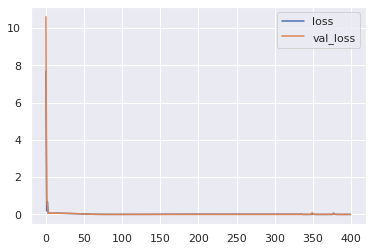

In [11]:
plt.plot(loss_values[:], label="loss")
plt.plot(val_loss_values[:], label="val_loss")
plt.legend()
plt.show()

In [12]:
mv_net.eval()
mv_net.init_hidden(testX.size(0))
test_predict = mv_net(testX).detach().numpy()

test_predict = target_scaler.inverse_transform(test_predict.reshape(-1, 1))

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test_predict[:,0],daily_data_with_weather['Energy_Generated'].iloc[train_size + n_timesteps::1] ,squared=False)
print("RMSE = %d" % rmse) 

RMSE = 1673


(1768, 1)
(1768,)


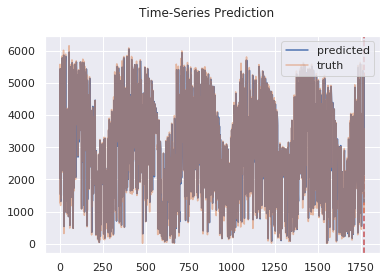

In [13]:
mv_net.init_hidden(trainX.size(0))
train_predict = mv_net(trainX)
train_predict = train_predict.data.numpy()
print(train_predict.shape)

train_truth = daily_data_with_weather['Energy_Generated'].iloc[90:train_size + 90:1]
print(train_truth.shape)
train_predict = target_scaler.inverse_transform(train_predict.reshape(-1,1))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(train_predict[:,0], label="predicted")
plt.plot(train_truth.values, alpha=0.5, label="truth")
plt.suptitle('Time-Series Prediction')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

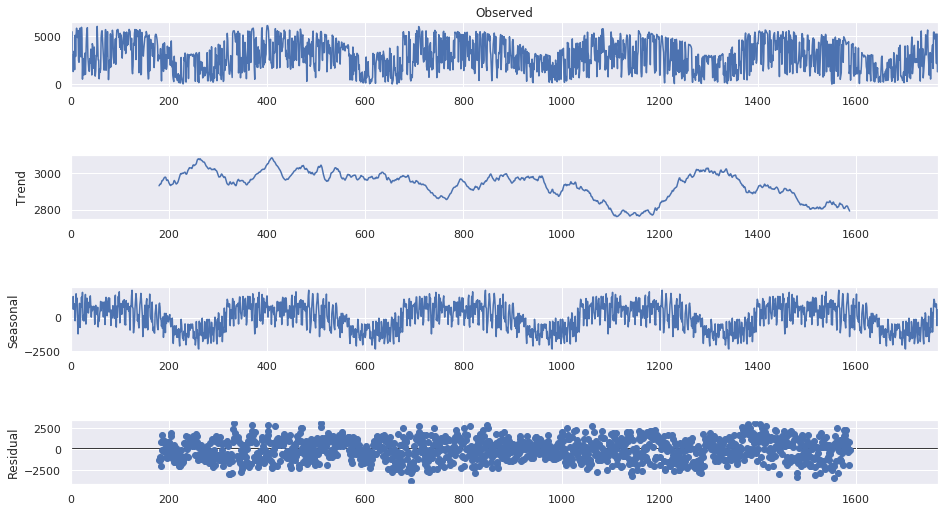

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(train_predict[:,0],period=360) 

fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

mean = -7.81365
std  = 1715.6682
-5.9176025
0.7900772668061556


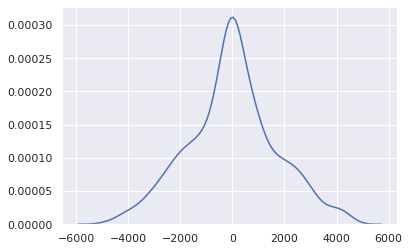

In [15]:
residuals = train_predict[:,0] - train_truth.values
sns.kdeplot(residuals)
print("mean =", np.mean(residuals))
print("std  =", np.std(residuals))
print(np.median(residuals))
from scipy import stats
k2, p  = stats.normaltest(residuals)
print(p)

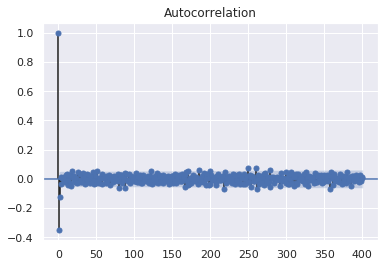

In [19]:
import statsmodels.api as sm
acf = sm.graphics.tsa.plot_acf(residuals, lags=400)